In [3]:
import pandas as pd
import numpy as np
import pypsa
import os
import matplotlib.pyplot as plt
import glob

In [4]:
run_dict = {
            "Baseline" : "results/Baseline_128n_3H/",
            "Tech" : "results/Tech_128n_3H/",
            "Life" : "results/Life_128n_3H/",
            "Tango" : "results/Tango_128n_3H_netzero/"
            }

In [10]:
#net_dict = {}
#for k in run_dict.keys():
#    print(k)
#    netdir = glob.glob(run_dict[k]+"/postnetworks/*.nc")[0]
#    net_dict[k] = pypsa.Network(netdir)

In [ ]:
def cycling_shift(df, steps=1):
    """Cyclic shift on index of pd.Series|pd.DataFrame by number of steps"""
    df = df.copy()
    new_index = np.roll(df.index, steps)
    df.values[:] = df.reindex(index=new_index).values
    return df

In [15]:
FLATTEN = True
FLATSCALE = 0.5

def flatten_loads(n):
    # electricity
    # land transport EV
    # all heats
    # 
    
    heat_systems = [
        "residential rural",
        "services rural",
        "residential urban decentral",
        "services urban decentral",
        "urban central"
    ]
    

In [234]:
n = pypsa.Network("results/Baseline_128n_3H/prenetworks/elec_sc_LTS_Baseline_s_128_lvopt__Co2L0p10-3H-T-H-B-I-A-seq1e9_2050.nc")
n.loads.carrier.unique()

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 0], imported network file PyPSA version [0, 19, 3].

INFO:pypsa.io:Imported network elec_sc_LTS_Baseline_s_128_lvopt__Co2L0p10-3H-T-H-B-I-A-seq1e9_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


array(['electricity', 'land transport EV', 'land transport fuel cell',
       'land transport oil', 'land transport oil emissions',
       'residential rural heat', 'services rural heat',
       'residential urban decentral heat',
       'services urban decentral heat', 'urban central heat',
       'solid biomass for industry', 'gas for industry',
       'H2 for industry', 'H2 for shipping', 'shipping oil',
       'shipping oil emissions', 'naphtha for industry',
       'kerosene for aviation', 'oil emissions',
       'low-temperature heat for industry', 'industry electricity',
       'process emissions', 'agriculture electricity', 'agriculture heat',
       'agriculture machinery electric', 'agriculture machinery oil',
       'agriculture machinery oil emissions'], dtype=object)

In [248]:
def flatten(n,carrier):
# timeseries becomes: timeseries*(1-FLATSCALE) + year_avg*FLATSCALE
    for ct in n.buses.country.dropna().unique():
        # TODO map onto n.bus.country
        loads_i = n.loads.index[(n.loads.index.str[:2] == ct) & (n.loads.carrier == carrier)]
        loads_i = n.loads_t.p_set.columns.intersection(loads_i)
        #if not loads_i in n.loads_t.p_set.columns : continue
        if n.loads_t.p_set[loads_i].empty: continue
        if FLATTEN:
            #print(loads_i)
            avg = pd.DataFrame(index  = n.loads_t.p_set[loads_i].index, columns = n.loads_t.p_set[loads_i].columns)
            for c in avg.columns:
                avg.loc[:,c] = n.loads_t.p_set[c].multiply(n.snapshot_weightings["generators"]).sum()/8760

            n.loads_t.p_set[loads_i] = FLATSCALE*avg + (1-FLATSCALE)*n.loads_t.p_set[loads_i]
            
def smoothen(df,window):
    dfc = df.copy()
    dfc_tot = dfc
    for i in range(1,int(window/2)+1):
        dfc_tot = dfc_tot + cycling_shift(dfc,i)
        #print(i,dfc_tot.sum())
    for i in range(1,int((window-1)/2)+1):
        dfc_tot = dfc_tot + cycling_shift(dfc,-1*i)
        #print(-1*i,dfc_tot.sum())
    dfc_tot = dfc_tot / window
    return dfc_tot

def flatten_heat(n,carrier):
# Performs moving average over a period of FLATSCALE*year (i.e., 0.08333333 ~= 1 month window)
    for ct in n.buses.country.dropna().unique():
        # TODO map onto n.bus.country
        loads_i = n.loads.index[(n.loads.index.str[:2] == ct) & (n.loads.carrier == carrier)]
        loads_i = n.loads_t.p_set.columns.intersection(loads_i)
        #if not loads_i in n.loads_t.p_set.columns : continue
        if n.loads_t.p_set[loads_i].empty: continue
        if FLATTEN:        
            n.loads_t.p_set[loads_i] = smoothen(n.loads_t.p_set[loads_i],n.snapshots.size*FLATSCALE)

def flatten_all_heat(n):
    print("Reducing all heat peaks by factor of ", FLATSCALE)
    carriers = n.loads.carrier.unique()
    heat_names = [c for c in carriers if "heat" in c]
    for h in heat_names:
        print(h)
        flatten_heat(n,h)
        
def flatten_all_elec(n):
    print("Reducing all electricity peaks by factor of ", FLATSCALE)
    carriers = n.loads.carrier.unique()
    elec_names = [c for c in carriers if "electric" in c or "EV" in c]
    for e in elec_names:
        print(e)
        flatten(n,e)

In [244]:
n.loads.carrier.unique()


array(['electricity', 'land transport EV', 'land transport fuel cell',
       'land transport oil', 'land transport oil emissions',
       'residential rural heat', 'services rural heat',
       'residential urban decentral heat',
       'services urban decentral heat', 'urban central heat',
       'solid biomass for industry', 'gas for industry',
       'H2 for industry', 'H2 for shipping', 'shipping oil',
       'shipping oil emissions', 'naphtha for industry',
       'kerosene for aviation', 'oil emissions',
       'low-temperature heat for industry', 'industry electricity',
       'process emissions', 'agriculture electricity', 'agriculture heat',
       'agriculture machinery electric', 'agriculture machinery oil',
       'agriculture machinery oil emissions'], dtype=object)

Load
GB0 2 residential rural heat    985075.234648
dtype: float64
Reducing all heat peaks by factor of  0.5
residential rural heat
services rural heat
residential urban decentral heat
services urban decentral heat
urban central heat
low-temperature heat for industry
agriculture heat
Load
GB0 2 residential rural heat    985075.234648
dtype: float64


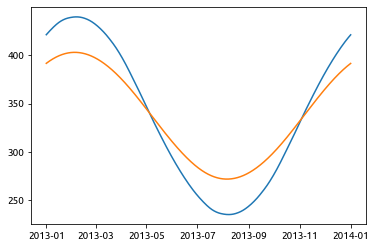

In [250]:
buses = ["GB0 2 residential rural heat"]#,"GB0 1 residential rural heat"]

plt.plot(n.loads_t.p_set[buses][:])
print(n.loads_t.p_set[buses][:].sum())

flatten_all_heat(n)

plt.plot(n.loads_t.p_set[buses][:])
print(n.loads_t.p_set[buses][:].sum())


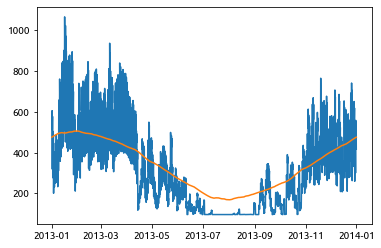

In [236]:
FLATSCALE = 0.5

buses = ["GB0 2 residential rural heat"]#,"GB0 1 residential rural heat"]

plt.plot(n.loads_t.p_set[buses][:])

#s = smoothen(n.loads_t.p_set[buses],8760/3/4)
flatten_heat(n,"residential rural heat")

#smoothen(n,"residential urban decentral heat")

#plt.plot(n.loads_t.p_set["FR1 0 residential urban decentral heat"][:])

plt.plot(n.loads_t.p_set[buses][:])


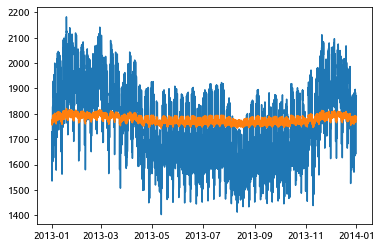

In [216]:
FLATSCALE = 0.9

plt.plot(n.loads_t.p_set["FR1 0"])

flatten(n,"electricity")

plt.plot(n.loads_t.p_set["FR1 0"])


#n.loads_t.p_set#['GB0 11 urban central heat']
#loads_i = n.loads.index[(n.loads.index.str[:2] == "GB") & (n.loads.carrier == "urban central heat")]
#n.loads_t.p_set.columns.intersection(loads_i)


In [203]:

#plt.plot(n.loads_t.p_set["FR1 0"])

for ct in n.buses.country.dropna().unique():
    # TODO map onto n.bus.country
    loads_i = n.loads.index[(n.loads.index.str[:2] == ct) & (n.loads.carrier == "electricity")]
    if n.loads_t.p_set[loads_i].empty: continue
    if FLATTEN and ct == "FR":
        #print(loads_i)
        minim = pd.DataFrame(index  = n.loads_t.p_set[loads_i].index, columns = n.loads_t.p_set[loads_i].columns)
        for c in minim.columns:
            minim.loc[:,c] = n.loads_t.p_set[c].min()

        #n.loads_t.p_set[loads_i] = minim + (1-FLATSCALE)*(n.loads_t.p_set[loads_i]-minim)


minim

#n.snapshot_weightings["generators"].divide(8760)
#plt.plot(n.loads_t.p_set["FR1 0"])
#n.loads_t.p_set[loads_i]

#n.loads_t.p_set[loads_i] *= factor

Load,FR1 0,FR1 1,FR1 10,FR1 11,FR1 12,FR1 13,FR1 14,FR1 15,FR1 16,FR1 17,FR1 18,FR1 2,FR1 3,FR1 4,FR1 5,FR1 6,FR1 7,FR1 8,FR1 9
snapshot,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,1591.916647,1134.016762,1677.460196,1608.578782,1198.998208,2111.448247,1274.7446,2089.894439,989.615031,2050.90841,1026.26694,6147.763096,1078.627317,1936.99581,1107.788253,1180.104587,987.316154,1131.519077,930.887235
2013-01-01 03:00:00,1591.916647,1134.016762,1677.460196,1608.578782,1198.998208,2111.448247,1274.7446,2089.894439,989.615031,2050.90841,1026.26694,6147.763096,1078.627317,1936.99581,1107.788253,1180.104587,987.316154,1131.519077,930.887235
2013-01-01 06:00:00,1591.916647,1134.016762,1677.460196,1608.578782,1198.998208,2111.448247,1274.7446,2089.894439,989.615031,2050.90841,1026.26694,6147.763096,1078.627317,1936.99581,1107.788253,1180.104587,987.316154,1131.519077,930.887235
2013-01-01 09:00:00,1591.916647,1134.016762,1677.460196,1608.578782,1198.998208,2111.448247,1274.7446,2089.894439,989.615031,2050.90841,1026.26694,6147.763096,1078.627317,1936.99581,1107.788253,1180.104587,987.316154,1131.519077,930.887235
2013-01-01 12:00:00,1591.916647,1134.016762,1677.460196,1608.578782,1198.998208,2111.448247,1274.7446,2089.894439,989.615031,2050.90841,1026.26694,6147.763096,1078.627317,1936.99581,1107.788253,1180.104587,987.316154,1131.519077,930.887235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,1591.916647,1134.016762,1677.460196,1608.578782,1198.998208,2111.448247,1274.7446,2089.894439,989.615031,2050.90841,1026.26694,6147.763096,1078.627317,1936.99581,1107.788253,1180.104587,987.316154,1131.519077,930.887235
2013-12-31 12:00:00,1591.916647,1134.016762,1677.460196,1608.578782,1198.998208,2111.448247,1274.7446,2089.894439,989.615031,2050.90841,1026.26694,6147.763096,1078.627317,1936.99581,1107.788253,1180.104587,987.316154,1131.519077,930.887235
2013-12-31 15:00:00,1591.916647,1134.016762,1677.460196,1608.578782,1198.998208,2111.448247,1274.7446,2089.894439,989.615031,2050.90841,1026.26694,6147.763096,1078.627317,1936.99581,1107.788253,1180.104587,987.316154,1131.519077,930.887235


array(['electricity', 'land transport EV', 'land transport fuel cell',
       'land transport oil', 'land transport oil emissions',
       'residential rural heat', 'services rural heat',
       'residential urban decentral heat',
       'services urban decentral heat', 'urban central heat',
       'solid biomass for industry', 'gas for industry',
       'H2 for industry', 'H2 for shipping', 'shipping oil',
       'shipping oil emissions', 'naphtha for industry',
       'kerosene for aviation', 'oil emissions',
       'low-temperature heat for industry', 'industry electricity',
       'process emissions', 'agriculture electricity', 'agriculture heat',
       'agriculture machinery electric', 'agriculture machinery oil',
       'agriculture machinery oil emissions'], dtype=object)

In [7]:
n = net_dict["Baseline"]
for ct in n.buses.country.dropna().unique():
        # TODO map onto n.bus.country
        loads_i = n.loads.index[(n.loads.index.str[:2] == ct) & (n.loads.carrier == "electricity")]
        

In [9]:
n.loads

,bus,carrier,p_set,type,q_set,sign
Load,,,,,,
AL1 0,AL1 0 low voltage,electricity,0.000000,,0.0,-1.0
AT1 0,AT1 0 low voltage,electricity,0.000000,,0.0,-1.0
AT1 1,AT1 1 low voltage,electricity,0.000000,,0.0,-1.0
BA1 0,BA1 0 low voltage,electricity,0.000000,,0.0,-1.0
BE1 0,BE1 0 low voltage,electricity,0.000000,,0.0,-1.0
...,...,...,...,...,...,...
SE2 4 agriculture machinery electric,SE2 4 low voltage,agriculture machinery electric,10.177344,,0.0,-1.0
SI1 0 agriculture machinery electric,SI1 0 low voltage,agriculture machinery electric,4.100258,,0.0,-1.0
SK1 0 agriculture machinery electric,SK1 0 low voltage,agriculture machinery electric,7.120432,,0.0,-1.0
